In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.integrate import odeint, ode, solve_ivp
import seaborn as sns
from copy import deepcopy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from scipy import interpolate
from scipy.interpolate import CubicSpline
import warnings
warnings.filterwarnings("ignore")
%run -i '../../../../../utils.py'

# Read data

In [2]:
# read metadata
df_meta = pd.read_excel('../../../../../our_data/meta_data.xlsx', index_col=0)
df_meta = df_meta[df_meta.Diet=='Inulin']
df_meta = df_meta.drop('Diet', axis=1)
df_meta = df_meta.rename({'MiceID':'SubjectID'}, axis=1)

# read SCFA
df_scfa = pd.read_excel('../../../../../our_data/SCFA.xlsx', index_col=0)

# read bacterial absolute abundance
df_bac = pd.read_excel('../../../../../our_data/16S_absolute_abundance.xlsx', index_col=0)
df_bac = df_bac/df_bac.max().max()

# Intrapolation

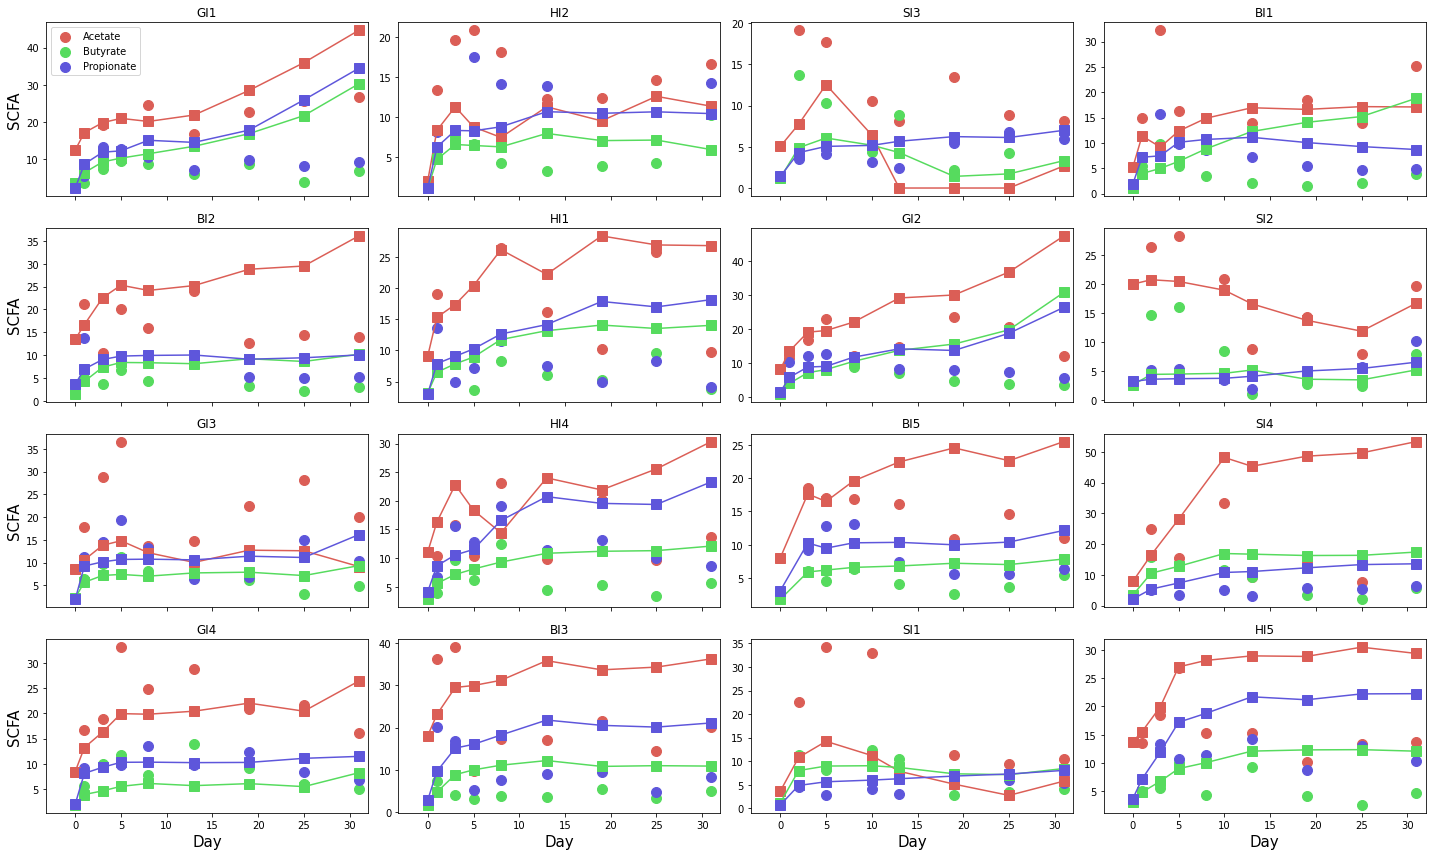

In [3]:
df_intra = get_rf_prediction_error(
    df_meta=df_meta,
    df_scfa=df_scfa,
    df_bac=df_bac,
    target_scfa=['Acetate','Butyrate','Propionate'],
    prediction_type='intrapolation',
    topN=40,
    is_plot=True,
    save_fig=False,
    use_deriv_scfa=True,
    use_deriv_microbiome=True
)
df_intra.to_csv('prediction_error_intrapolation.csv')

# Extrapolation

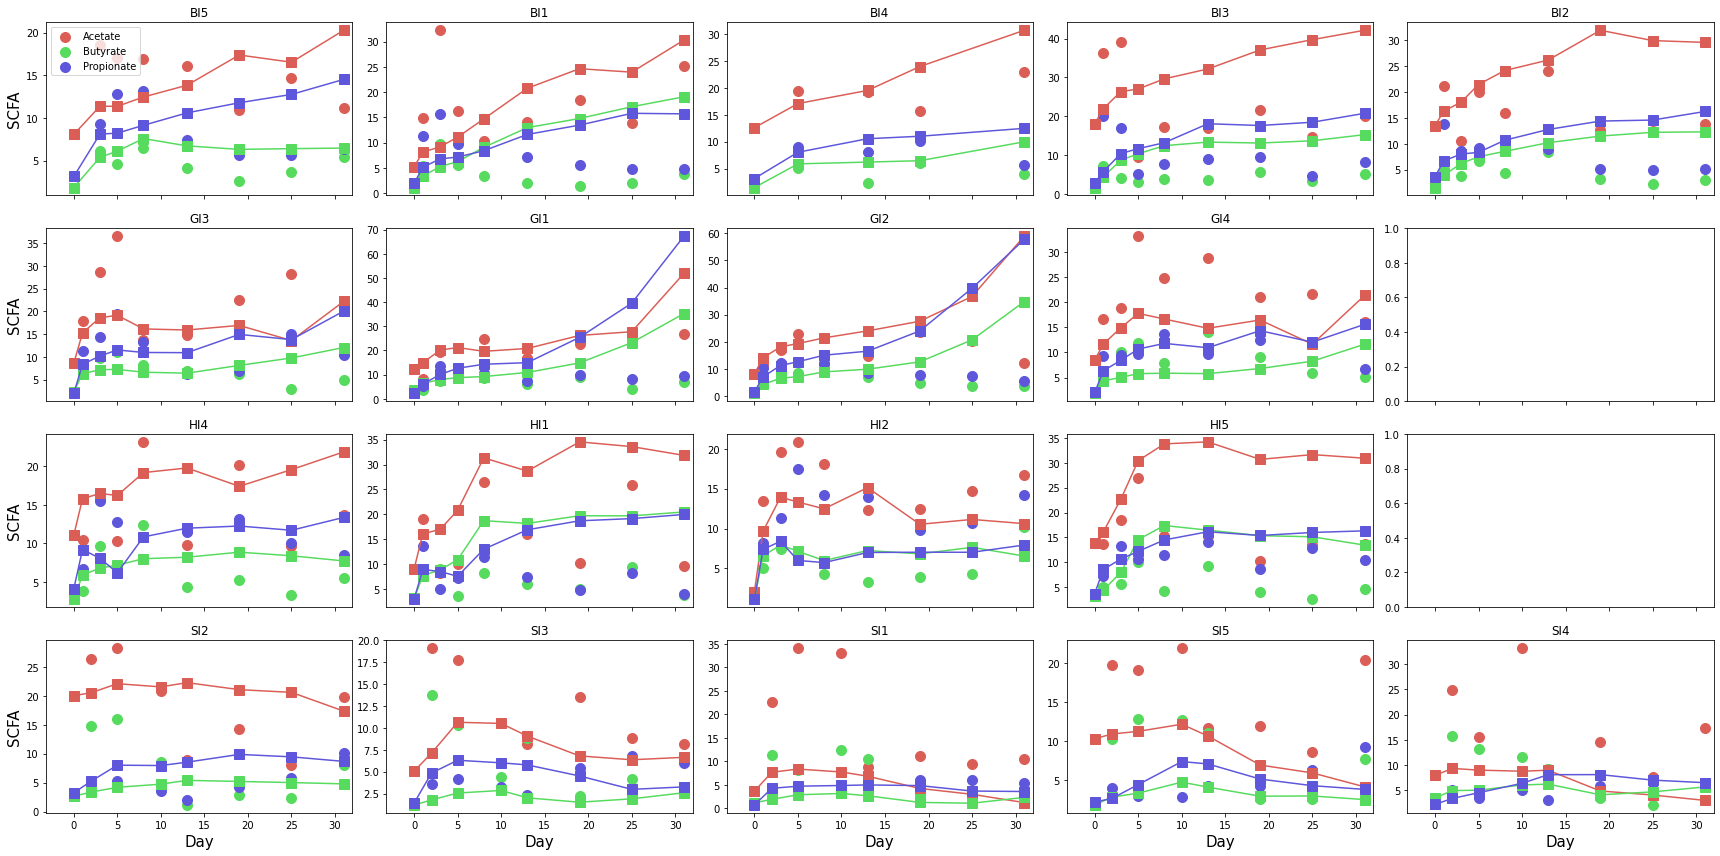

In [4]:
df_extra = get_rf_prediction_error(
    df_meta=df_meta,
    df_scfa=df_scfa,
    df_bac=df_bac,
    target_scfa=['Acetate','Butyrate','Propionate'],
    prediction_type='extrapolation',
    topN=40,
    is_plot=True,
    save_fig=False,
    use_deriv_scfa=True,
    use_deriv_microbiome=True
)
df_extra.to_csv('prediction_error_extrapolation.csv')

# Plot training vs. prediction

In [8]:
df_intra = pd.read_csv('prediction_error_intrapolation.csv', index_col=0)
df_intra['Perturbation'] = 'intrapolation'
df_extra = pd.read_csv('prediction_error_extrapolation.csv', index_col=0)
df_extra['Perturbation'] = 'extrapolation'
df_train_test = pd.concat([df_intra,df_extra], ignore_index=True)
df_train_test.to_csv('prediction_error_combined.csv')
df_train_test.head()

,SubjectID,Vendor,Day,RandomizedGroup,SCFA_value_observed,SCFA_deriv_observed,SCFA_deriv_predicted,SCFA_mol,SCFA_value_predicted,RelativeError,Perturbation
0,GI1,Guangdong,0,A,12.466773,-11.331097,6.119767,Acetate,12.466773,0.000000,intrapolation
1,GI1,Guangdong,1,A,8.228369,1.576644,4.075646,Acetate,17.134511,108.237014,intrapolation
2,GI1,Guangdong,3,A,19.310101,4.394505,1.445360,Acetate,19.836100,2.723958,intrapolation
3,GI1,Guangdong,5,A,21.075157,0.115519,0.574614,Acetate,20.974835,-0.476020,intrapolation
4,GI1,Guangdong,8,A,24.674920,0.401786,-1.144427,Acetate,20.148724,-18.343305,intrapolation


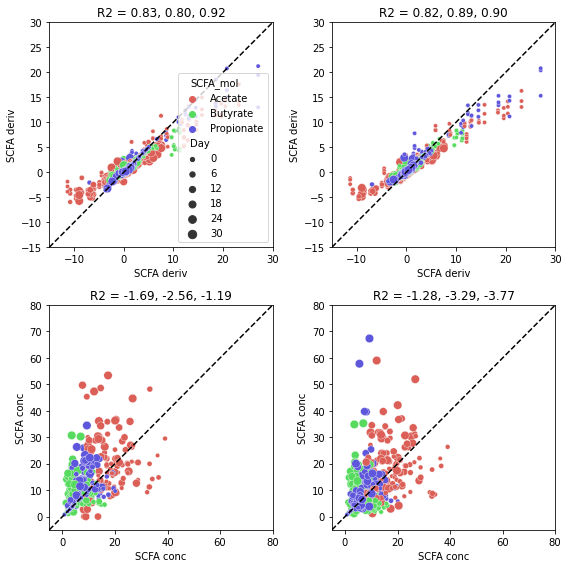

In [12]:
fig, ax = plt.subplots(figsize=(8,8), nrows=2, ncols=2)

lines_R2 = []
df = pd.read_csv('intrapolation/training_error_intrapolation.csv')
_ = sns.scatterplot(x='SCFA_deriv_observed',y='SCFA_deriv_predicted', hue='SCFA_mol', size='Day', palette=sns.color_palette("hls", 3), data=df, ax=ax[0,0])
_ = ax[0,0].plot([-15,30],[-15,30],'k--')
_ = ax[0,0].set_xlim([-15,30])
_ = ax[0,0].set_ylim([-15,30])
_ = ax[0,0].set_xlabel('SCFA deriv')
_ = ax[0,0].set_ylabel('SCFA deriv')

r2_ac = r2_score(df[df.SCFA_mol=='Acetate'].SCFA_deriv_observed, df[df.SCFA_mol=='Acetate'].SCFA_deriv_predicted)
r2_but = r2_score(df[df.SCFA_mol=='Butyrate'].SCFA_deriv_observed, df[df.SCFA_mol=='Butyrate'].SCFA_deriv_predicted)
r2_ppa = r2_score(df[df.SCFA_mol=='Propionate'].SCFA_deriv_observed, df[df.SCFA_mol=='Propionate'].SCFA_deriv_predicted)
lines_R2.append(['intrapolation','training','acetate',r2_ac])
lines_R2.append(['intrapolation','training','butyrate',r2_but])
lines_R2.append(['intrapolation','training','propionate',r2_ppa])
_ = ax[0,0].set_title('R2 = %2.2f, %2.2f, %2.2f'%(r2_ac,r2_but,r2_ppa))

df = pd.read_csv('extrapolation/training_error_extrapolation.csv')
_ = sns.scatterplot(x='SCFA_deriv_observed',y='SCFA_deriv_predicted', hue='SCFA_mol', size='Day', palette=sns.color_palette("hls", 3), data=df, ax=ax[0,1])
_ = ax[0,1].plot([-15,30],[-15,30],'k--')
_ = ax[0,1].set_xlim([-15,30])
_ = ax[0,1].set_ylim([-15,30])
_ = ax[0,1].set_xlabel('SCFA deriv')
_ = ax[0,1].set_ylabel('SCFA deriv')

r2_ac = r2_score(df[df.SCFA_mol=='Acetate'].SCFA_deriv_observed, df[df.SCFA_mol=='Acetate'].SCFA_deriv_predicted)
r2_but = r2_score(df[df.SCFA_mol=='Butyrate'].SCFA_deriv_observed, df[df.SCFA_mol=='Butyrate'].SCFA_deriv_predicted)
r2_ppa = r2_score(df[df.SCFA_mol=='Propionate'].SCFA_deriv_observed, df[df.SCFA_mol=='Propionate'].SCFA_deriv_predicted)
lines_R2.append(['extrapolation','training','acetate',r2_ac])
lines_R2.append(['extrapolation','training','butyrate',r2_but])
lines_R2.append(['extrapolation','training','propionate',r2_ppa])
_ = ax[0,1].set_title('R2 = %2.2f, %2.2f, %2.2f'%(r2_ac,r2_but,r2_ppa))
ax[0,1].legend().remove()

for k,perturbation in enumerate(['intrapolation','extrapolation']):
    df = df_train_test[df_train_test.Perturbation==perturbation]
    _ = sns.scatterplot(x='SCFA_value_observed',y='SCFA_value_predicted', hue='SCFA_mol', size='Day', palette=sns.color_palette("hls", 3), data=df, ax=ax[1,k])
    _ = ax[1,k].plot([-5,80],[-5,80],'k--')
    _ = ax[1,k].set_xlim([-5,80])
    _ = ax[1,k].set_ylim([-5,80])
    r2_ac = r2_score(df[df.SCFA_mol=='Acetate'].SCFA_value_observed, df[df.SCFA_mol=='Acetate'].SCFA_value_predicted)
    r2_but = r2_score(df[df.SCFA_mol=='Butyrate'].SCFA_value_observed, df[df.SCFA_mol=='Butyrate'].SCFA_value_predicted)
    r2_ppa = r2_score(df[df.SCFA_mol=='Propionate'].SCFA_value_observed, df[df.SCFA_mol=='Propionate'].SCFA_value_predicted)
    lines_R2.append([perturbation,'testing','acetate',r2_ac])
    lines_R2.append([perturbation,'testing','butyrate',r2_but])
    lines_R2.append([perturbation,'testing','propionate',r2_ppa])
    _ = ax[1,k].set_title('R2 = %2.2f, %2.2f, %2.2f'%(r2_ac,r2_but,r2_ppa))
    ax[1,k].legend().remove()
    _ = ax[1,k].set_xlabel('SCFA conc')
    _ = ax[1,k].set_ylabel('SCFA conc')
            
plt.tight_layout()

df_r2 = pd.DataFrame(lines_R2, columns=['Perturbation','Split','SCFA','R2'])

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("scatter_plot_training_prediction.svg", format="svg")

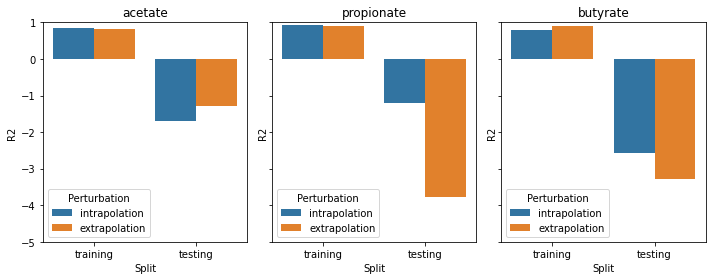

In [15]:
fig,ax = plt.subplots(figsize=(10,4), nrows=1, ncols=3, sharey=True)

for k,scfa_ in enumerate(['acetate','propionate','butyrate']):
    _ = sns.barplot(x='Split', y='R2', hue='Perturbation', data=df_r2[df_r2.SCFA==scfa_], ax=ax[k])
    ax[k].set_ylim([-5,1])
    ax[k].set_title(scfa_)
    
plt.tight_layout()

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("barplot_R2_training_prediction.svg", format="svg")